# Prueba técnica Data Science


En Los Ángeles existe un sistema compartido de bicicletas que brinda datos anónimos acerca
del uso del servicio. La tabla que se proporciona contiene el histórico de viajes que se han
realizado desde 2016 y contiene una columna que es de particular interés y que se buscará
analizar a más profundidad: Passholder_type. A continuación se presentan las columnas
que contiene la tabla:

- trip_id: identificador único para el viaje
- duration: duración del viaje en minutos
- start_time: dia/hora donde en viaje inicia en formato ISO 8601 - tiempo local
- end_time: dia/hora donde el viaje termina en formato ISO 8601 tiempo local
- start_station: la estación donde el viaje inició
- start_lat: la latitud de la estación donde el viaje se originó
- start_lon: la longitud de la estación donde el viaje se originó
- end_station: la estación donde el viaje terminó
- end_lat: la latitud de la estación donde terminó el viaje
- end_lon: la longitud de la estación donde terminó el viaje
- bike_id: un entero único que identifica la bicicleta
- plan_duration: número de días que el usuario tendrá el paso. 0 significa un viaje único (Walk-up plan)
- trip_route_category: “Round trip” son viajes que empiezan y terminan en la misma estación
- passholder_type: El nombre del plan de passholder

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import seaborn as sns
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=[15.0,5.0]
sns.set(style="darkgrid")
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from libraries import *
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingClassifier


In [2]:
df_sample_submission = pd.read_csv('sample_submission.csv')
df_test_set = pd.read_csv('test_set.csv')
df_train_set = pd.read_csv('train_set.csv')

In [3]:
df_train_set.head()

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,1.0,Round Trip,Walk-up,4127,4127
1,46560345,32,9/17/2017 17:51,9/17/2017 18:23,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062
3,129547190,138,9/22/2019 11:27,9/22/2019 13:45,34.062580,-118.290092,34.059689,-118.294662,17068,1.0,One Way,One Day Pass,4304,4311
4,136619463,14,1/31/2020 17:11,1/31/2020 17:25,34.026291,-118.277687,34.021660,-118.278687,18841,30.0,One Way,Monthly Pass,4266,4443


In [4]:
df_test_set.head()

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,start_station,end_station
0,17059130,12,1/1/2017 0:24,1/1/2017 0:36,34.058319,-118.246094,34.058319,-118.246094,6351,Round Trip,3028,3028
1,17059129,17,1/1/2017 0:28,1/1/2017 0:45,34.049980,-118.247162,34.043732,-118.260139,5836,One Way,3027,3018
2,17059126,20,1/1/2017 0:39,1/1/2017 0:59,34.063389,-118.236160,34.044159,-118.251579,6529,One Way,3066,3055
3,17059125,12,1/1/2017 0:43,1/1/2017 0:55,34.048851,-118.246422,34.050140,-118.233238,6029,One Way,3029,3079
4,17061379,48,1/1/2017 0:56,1/1/2017 1:44,34.049198,-118.252831,34.049198,-118.252831,6680,Round Trip,3063,3063


In [5]:
df_sample_submission.head()

,trip_id,passholder_type
0,17059130,Monthly Pass
1,17059129,Monthly Pass
2,17059126,Monthly Pass
3,17059125,Monthly Pass
4,17061379,Monthly Pass


## 1) Exploratorio de datos

- Saturación del servicio: La empresa busca contar con la disponibilidad más alta
de servicio en el mercado, por lo que se quiere entender cómo se comporta la
demanda de servicio en las distintas estaciones y horarios para cada plan

In [6]:
for col in df_train_set:
    print("--------------------")
    print(df_train_set[col].value_counts(), '\n')
    print("--------------------")

--------------------
101750280    1
32793803     1
83674919     1
62376663     1
76621391     1
            ..
39769658     1
148272136    1
149039733    1
132809531    1
167744702    1
Name: trip_id, Length: 700000, dtype: int64 

--------------------
--------------------
5       39286
6       38948
7       36988
4       35409
8       33329
        ...  
1340        1
1235        1
1379        1
1145        1
965         1
Name: duration, Length: 1434, dtype: int64 

--------------------
--------------------
2018-10-03 09:29:00    12
2017-10-08 14:12:00     8
2018-06-25 18:30:00     8
2018-09-30 10:36:00     7
2019-03-03 13:15:00     7
                       ..
9/5/2017 8:47           1
3/29/2017 15:47         1
2018-05-14 18:27:00     1
2017-05-24 12:03:00     1
2019-02-04 14:16:00     1
Name: start_time, Length: 567695, dtype: int64 

--------------------
--------------------
2018-07-17 17:08:00    12
2018-08-04 12:41:00    12
2018-02-03 19:42:00    11
2017-10-08 16:21:00    10
2019

In [7]:
df_eda = df_train_set.copy()

In [8]:
df_eda['start_time'] = pd.to_datetime(df_eda.start_time,errors="coerce", infer_datetime_format=True, dayfirst= False )
df_eda['end_time'] = pd.to_datetime(df_eda.end_time,errors="coerce", infer_datetime_format=True, dayfirst= False )


In [9]:
def f(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Eve'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'

df_eda['time_day'] = df_eda.start_time.dt.hour
df_eda['time_day'] = df_eda['time_day'].apply(f)

df_eda.time_day.value_counts()

Noon             211054
Eve              192344
Morning          159896
Early Morning     69015
Night             49702
Late Night        17989
Name: time_day, dtype: int64

([<matplotlib.patches.Wedge at 0x7f40f51f0760>,
 [Text(-0.17721528127340228, 1.0856310349668479, 'Noon'),
  Text(-1.0125407610724142, -0.42983858268761344, 'Eve'),
  Text(0.43999584340356124, -1.008168466967495, 'Morning'),
  Text(1.090440337029418, -0.1447061552912291, 'Early Morning'),
  Text(1.0127952498621975, 0.429238607136601, 'Night'),
  Text(0.8380124120221247, 0.7125553994580779, 'Late Night')],
 [Text(-0.09666288069458305, 0.5921623827091896, '30.2%'),
  Text(-0.5522949605849532, -0.23445740873869822, '27.5%'),
  Text(0.23999773276557884, -0.5499100728913608, '22.8%'),
  Text(0.5947856383796825, -0.07893063015885222, '9.9%'),
  Text(0.5524337726521076, 0.2341301493472369, '7.1%'),
  Text(0.4570976792847953, 0.3886665815225879, '2.6%')])

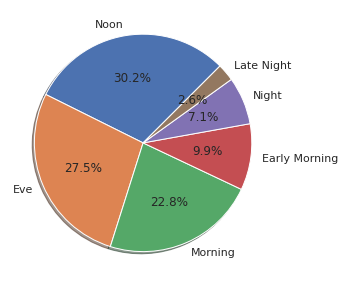

In [10]:
df_tmp = df_eda.time_day.value_counts()
plt.pie(df_tmp.values, labels=df_tmp.index,shadow=True, autopct='%1.1f%%',startangle=45)


No handles with labels found to put in legend.


Int64Index([31, 29, 30, 23, 25, 24,  7,  9, 12,  1, 15, 14, 26, 22,  5, 11, 17,
            20, 28, 27, 19, 16, 13,  2,  4, 21, 10,  8,  3, 18,  6],
           dtype='int64')

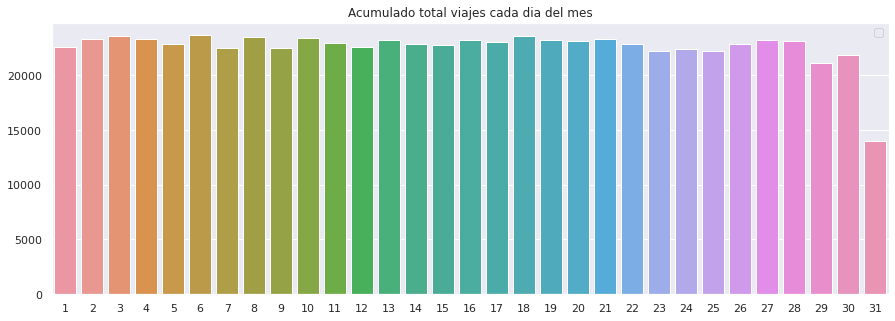

In [11]:
df_tmp = df_eda.copy()
df_tmp['day_month'] = df_tmp.start_time.dt.day
df_tmp = df_tmp.day_month.value_counts()
df_tmp = df_tmp.sort_values()
#df_tmp=df_tmp.resample('H').sum()
sns.barplot(df_tmp.index, df_tmp.values).set_title("Acumulado total viajes cada dia del mes")
plt.legend()
df_tmp.index

No handles with labels found to put in legend.


Int64Index([ 3,  4,  5,  2,  1,  0,  6, 23, 22,  7, 21, 20, 10,  9,  8, 11, 19,
            14, 12, 15, 13, 18, 16, 17],
           dtype='int64')

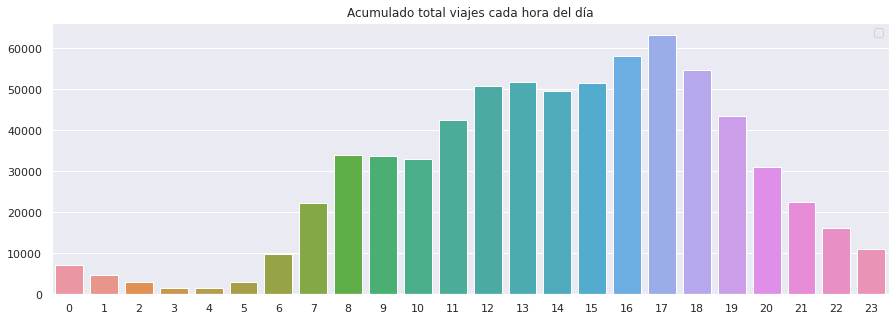

In [12]:
df_tmp = df_eda.copy()
df_tmp['hour'] = df_tmp.start_time.dt.hour
df_tmp = df_tmp.hour.value_counts()
df_tmp = df_tmp.sort_values()
#df_tmp=df_tmp.resample('H').sum()
sns.barplot(df_tmp.index, df_tmp.values).set_title("Acumulado total viajes cada hora del día")
plt.legend()
df_tmp.index

No handles with labels found to put in legend.


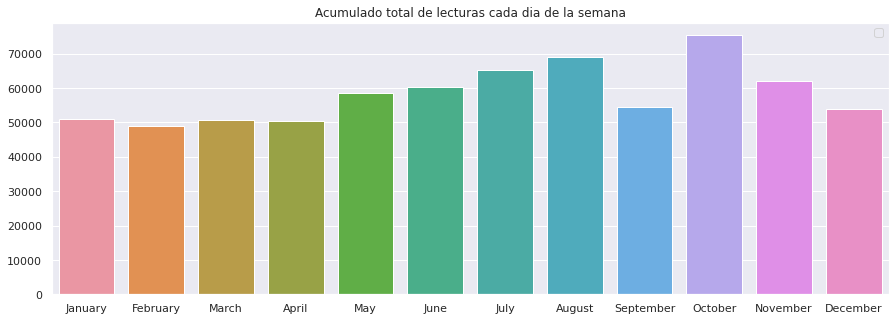

In [13]:
df_tmp = df_eda.copy()
df_tmp['day_month'] = df_tmp.start_time.dt.month_name()
df_tmp = df_tmp.day_month.value_counts()
df_tmp = df_tmp.sort_values()

order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sns.barplot(df_tmp.index, df_tmp.values, order=order).set_title("Acumulado total de lecturas cada dia de la semana")
plt.legend()

No handles with labels found to put in legend.


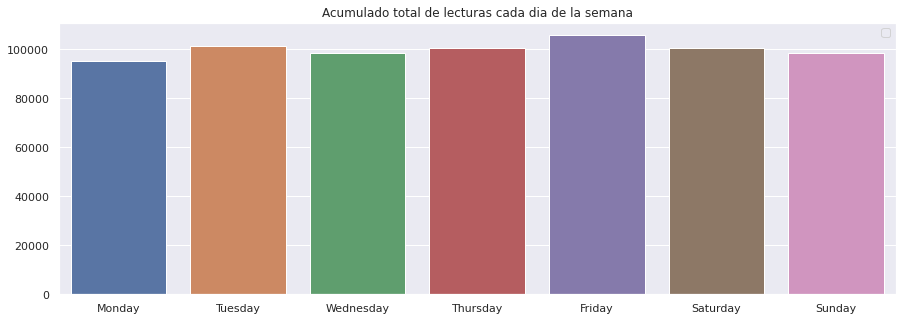

In [14]:
df_tmp = df_eda.copy()
df_tmp['day_name'] = df_tmp.start_time.dt.day_name()
df_tmp = df_tmp.day_name.value_counts()
df_tmp = df_tmp.sort_values()

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(df_tmp.index, df_tmp.values, order=order).set_title("Acumulado total de lecturas cada dia de la semana")
plt.legend()

<AxesSubplot:xlabel='passholder_type'>

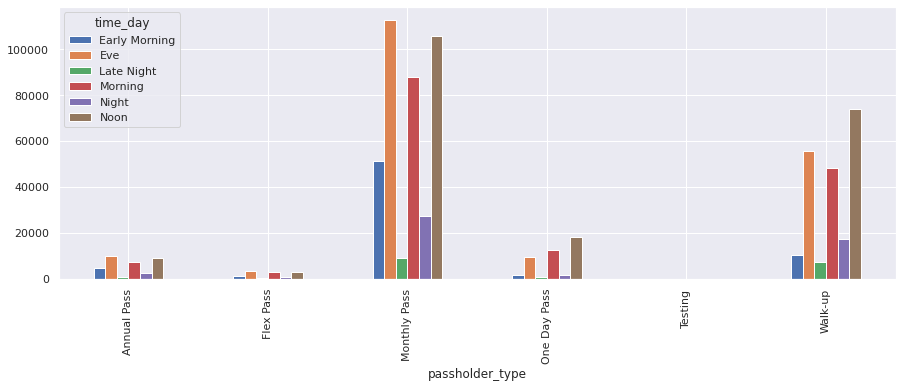

In [15]:
#por tipo d membresia en que hora del dia utliza el servicio
df_tmp = df_eda.groupby(["passholder_type",'time_day'])[["time_day"]].count().unstack()
df_tmp.columns = df_tmp.columns.droplevel()
df_tmp.plot.bar()


<AxesSubplot:xlabel='passholder_type'>

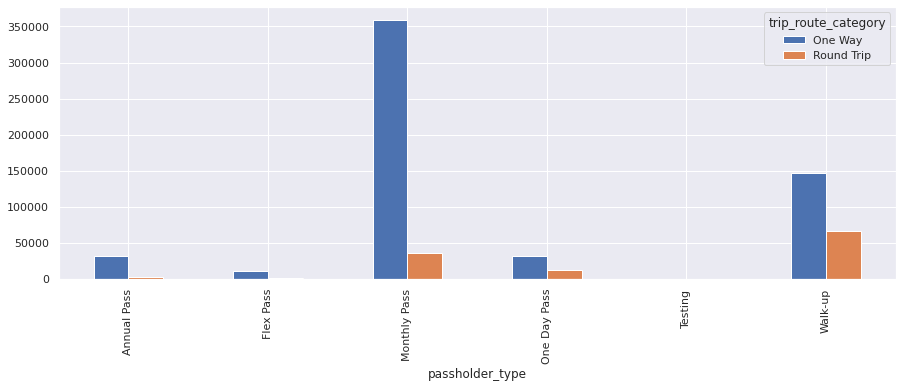

In [16]:
#el tipo de ruta de biaje por el tipo de membresia
df_tmp = df_eda.groupby(["passholder_type",'trip_route_category'])[["trip_route_category"]].count().unstack()
df_tmp.columns = df_tmp.columns.droplevel()
df_tmp.plot.bar()

- Crecimiento de planes: Se tiene la intuición que la tendencia en uso de
bicicletas compartidas entre estaciones va a la alta, por lo que se requiere
realizar una correcta planificación de bicicletas que deben tener.
Adicionalmente, se espera que los planes de consumo anual crezcan en mayor
proporción.

In [17]:
df_tmp = df_eda.copy()
df_tmp.start_time=pd.to_datetime(df_tmp.start_time)
df_tmp.start_time = df_tmp.start_time.dt.date
df_tmp = df_tmp.start_time.value_counts()
df_tmp.index=pd.to_datetime(df_tmp.index)

df_fechas = pd.DataFrame(index = pd.date_range(start = min(df_tmp.index), end = max(df_tmp.index)))
df_fechas.index = df_fechas.index.date
df_fechas = pd.merge(df_fechas, df_tmp, how='left',left_index=True,right_index=True)
df_fechas=df_fechas.resample('M').sum()
df_fechas

,start_time
2016-10-31,9940.0
2016-11-30,7926.0
2016-12-31,5899.0
2017-01-31,5713.0
2017-02-28,5247.0
...,...
2021-08-31,10989.0
2021-09-30,0.0
2021-10-31,10372.0
2021-11-30,8261.0


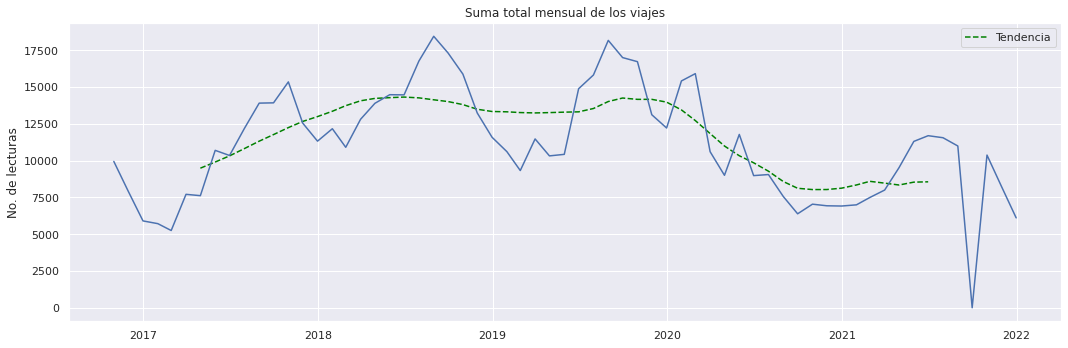

In [18]:
df_tmp = df_eda.copy()
df_tmp.start_time=pd.to_datetime(df_tmp.start_time)
df_tmp.start_time = df_tmp.start_time.dt.date
df_tmp = df_tmp.start_time.value_counts()
df_tmp.index=pd.to_datetime(df_tmp.index)

df_fechas = pd.DataFrame(index = pd.date_range(start = min(df_tmp.index), end = max(df_tmp.index)))
df_fechas.index = df_fechas.index.date
df_fechas = pd.merge(df_fechas, df_tmp, how='left',left_index=True,right_index=True)
df_fechas=df_fechas.resample('M').sum()

decom = sm.tsa.seasonal_decompose(df_fechas, model = 'additive')
fig, ax = plt.subplots() 
ax.plot(decom.trend.index, decom.trend.values, label = 'Tendencia', linestyle='--', color='green')
ax.plot(df_fechas.index,df_fechas['start_time'])
plt.title('Suma total mensual de los viajes')
plt.ylabel("No. de lecturas")
plt.legend()
plt.tight_layout()


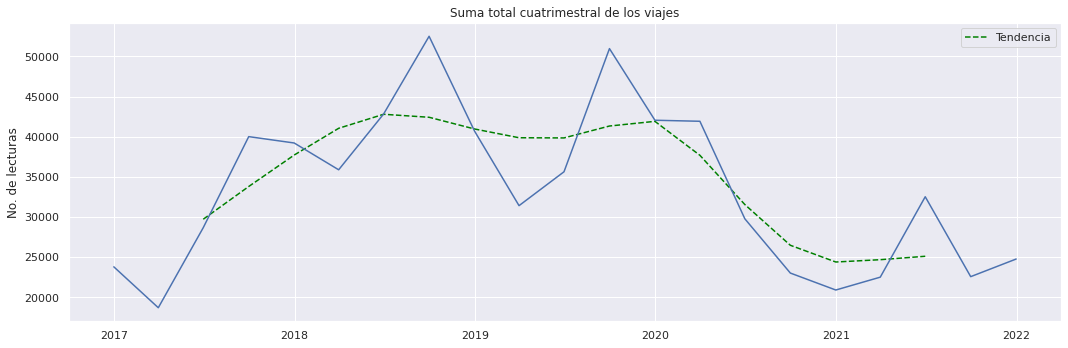

In [19]:
df_tmp = df_eda.copy()
df_tmp.start_time=pd.to_datetime(df_tmp.start_time)
df_tmp.start_time = df_tmp.start_time.dt.date
df_tmp = df_tmp.start_time.value_counts()
df_tmp.index=pd.to_datetime(df_tmp.index)

df_fechas = pd.DataFrame(index = pd.date_range(start = min(df_tmp.index), end = max(df_tmp.index)))
df_fechas.index = df_fechas.index.date
df_fechas = pd.merge(df_fechas, df_tmp, how='left',left_index=True,right_index=True)
df_fechas=df_fechas.resample('Q').sum()

decom = sm.tsa.seasonal_decompose(df_fechas, model = 'additive')
fig, ax = plt.subplots() 
ax.plot(decom.trend.index, decom.trend.values, label = 'Tendencia', linestyle='--', color='green')
ax.plot(df_fechas.index,df_fechas['start_time'])
plt.title('Suma total cuatrimestral de los viajes')
plt.ylabel("No. de lecturas")
plt.legend()
plt.tight_layout()



No handles with labels found to put in legend.


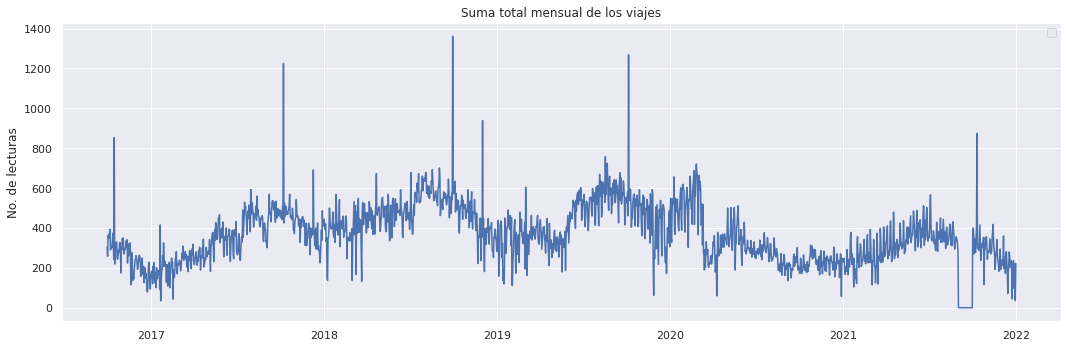

In [20]:
df_tmp = df_eda.copy()
df_tmp.start_time=pd.to_datetime(df_tmp.start_time)
df_tmp.start_time = df_tmp.start_time.dt.date
df_tmp = df_tmp.start_time.value_counts()
df_tmp.index=pd.to_datetime(df_tmp.index)

df_fechas = pd.DataFrame(index = pd.date_range(start = min(df_tmp.index), end = max(df_tmp.index)))
df_fechas.index = df_fechas.index.date
df_fechas = pd.merge(df_fechas, df_tmp, how='left',left_index=True,right_index=True)
df_fechas=df_fechas.resample('D').sum()

fig, ax = plt.subplots() 
ax.plot(df_fechas.index,df_fechas['start_time'])
plt.title('Suma total mensual de los viajes')
plt.ylabel("No. de lecturas")
plt.legend()
plt.tight_layout()


In [21]:
df_tmp = df_eda.copy()
df_tmp.start_time=pd.to_datetime(df_tmp.start_time)
df_tmp.start_time = df_tmp.start_time.dt.date
df_tmp['passholder_type'] = df_tmp['passholder_type'].astype('category')
df_tmp = df_tmp.groupby(['passholder_type']).start_time.value_counts()
df_tmp = pd.DataFrame(df_tmp)
df_tmp.reset_index(level=0, inplace=True)
df_tmp["value_counts"] = df_tmp["start_time"]
df_tmp = df_tmp.drop('start_time', axis=1)
df_tmp.index=pd.to_datetime(df_tmp.index)
df_tmp = df_tmp.sort_index()

#save all lector data
df_all_lector = pd.DataFrame(index = pd.date_range(start = min(df_tmp.index), end = max(df_tmp.index), freq='M'))
df_all_lector.index = df_all_lector.index.date

list_id_lector = df_tmp['passholder_type'].value_counts().index.to_list()
for i, passholder_type in enumerate(list_id_lector):
    new_df = df_tmp.copy()
    new_df = new_df.loc[new_df['passholder_type'] == passholder_type]
    #df fechas 
    df_fechas = pd.DataFrame(index = pd.date_range(start = min(df_tmp.index), end = max(df_tmp.index)))
    df_fechas.index = df_fechas.index.date
    #merge
    df_fechas = pd.merge(df_fechas, new_df, how='left',left_index=True,right_index=True)
    #resample
    df_fechas=df_fechas.resample('M').sum()
    df_all_lector[passholder_type] = df_fechas.iloc[:,0]

sum_lectores = df_all_lector.sum()
sum_lectores = sum_lectores.sort_values(ascending=False)
df_all_lector = df_all_lector[sum_lectores.sort_values(ascending=False).index[:]]

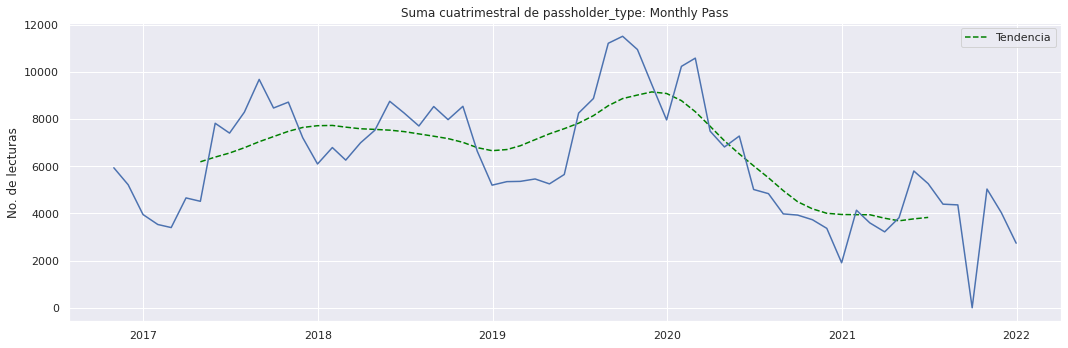

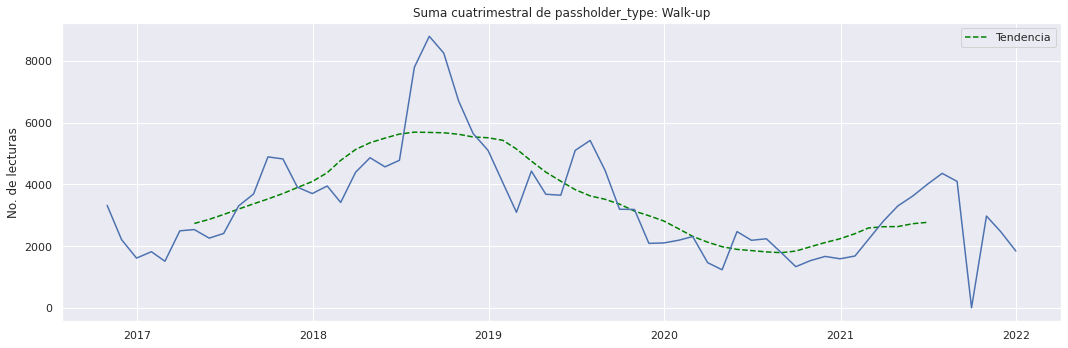

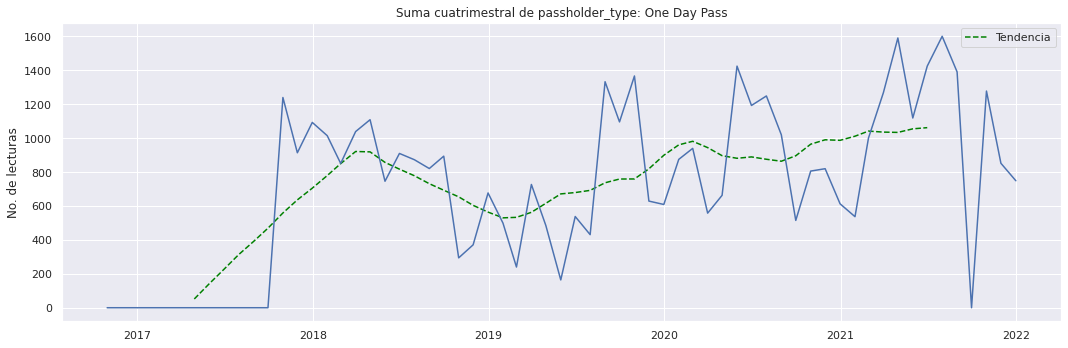

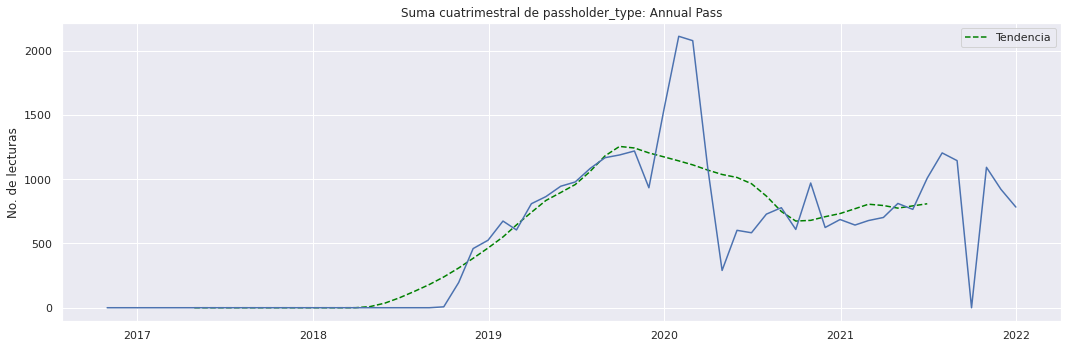

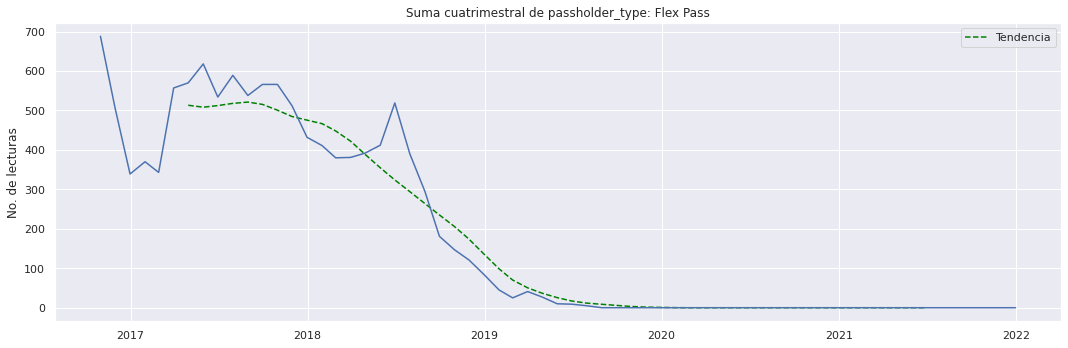

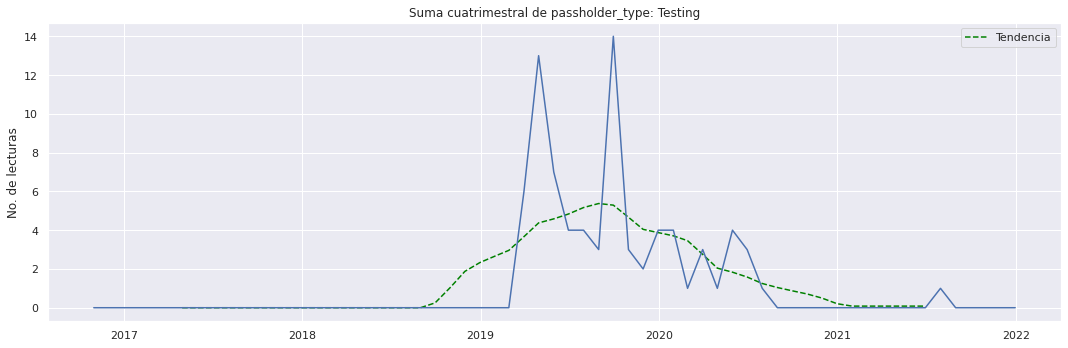

In [22]:
df_tmp = df_eda.copy()
df_tmp.start_time=pd.to_datetime(df_tmp.start_time)
df_tmp.start_time = df_tmp.start_time.dt.date
df_tmp['passholder_type'] = df_tmp['passholder_type'].astype('category')
df_tmp = df_tmp.groupby(['passholder_type']).start_time.value_counts()
df_tmp = pd.DataFrame(df_tmp)
df_tmp.reset_index(level=0, inplace=True)
df_tmp["value_counts"] = df_tmp["start_time"]
df_tmp = df_tmp.drop('start_time', axis=1)
df_tmp.index=pd.to_datetime(df_tmp.index)
df_tmp = df_tmp.sort_index()

#save all lector data
df_all_lector = pd.DataFrame(index = pd.date_range(start = min(df_tmp.index), end = max(df_tmp.index), freq='M'))
df_all_lector.index = df_all_lector.index.date

list_id_lector = df_tmp['passholder_type'].value_counts().index.to_list()
for i, passholder_type in enumerate(list_id_lector):
    new_df = df_tmp.copy()
    new_df = new_df.loc[new_df['passholder_type'] == passholder_type]
    #df fechas 
    df_fechas = pd.DataFrame(index = pd.date_range(start = min(df_tmp.index), end = max(df_tmp.index)))
    df_fechas.index = df_fechas.index.date
    #merge
    df_fechas = pd.merge(df_fechas, new_df, how='left',left_index=True,right_index=True)
    #resample
    df_fechas=df_fechas.resample('M').sum()
    df_all_lector[passholder_type] = df_fechas.iloc[:,0]

sum_lectores = df_all_lector.sum()
sum_lectores = sum_lectores.sort_values(ascending=False)
df_all_lector = df_all_lector[sum_lectores.sort_values(ascending=False).index[:]]
for i, passholder_type in enumerate(df_all_lector):
    df_tmp = df_all_lector[passholder_type]
    df_tmp.index=pd.to_datetime(df_tmp.index)
    decom = sm.tsa.seasonal_decompose(df_tmp, model = 'additive')
    fig, ax = plt.subplots() 
    ax.plot(decom.trend.index, decom.trend.values, label = 'Tendencia', linestyle='--', color='green')
    ax.plot(df_tmp.index,df_tmp.values)
    plt.title('Suma cuatrimestral de passholder_type: '+str(passholder_type))
    plt.ylabel("No. de lecturas")
    plt.legend()
    plt.tight_layout()

############################

In [23]:
# las estaciones mas utlizadas en cada parte del dia
pd.DataFrame(df_eda.groupby(['time_day','start_station'])['time_day'].count().nlargest(15)).add_suffix('_Count')

time_day_Count
time_day      start_station                
Eve           3005                     9805
Noon          3030                     9359
Early Morning 3014                     9041
Noon          4214                     7553
              3005                     6745
Morning       3005                     5942
Noon          4210                     5562
Eve           3035                     4768
              3064                     4759
              4214                     4731
Noon          3035                     4683
Eve           3030                     4585
              3031                     4520
Noon          4215                     4261
              3031                     4254

In [24]:
#la ruta mas comun por tiempo del dia y el promedio de cada viaje
df_tmp = df_eda.copy()
df_tmp['station_route'] = df_tmp['start_station'].astype(str) + '_' + df_tmp['end_station'].astype(str)
df_tmp = pd.DataFrame(df_tmp.groupby(['time_day','station_route']).agg({'time_day':['count'],'duration':['mean']})).reset_index()
df_tmp.columns = df_tmp.columns.droplevel()
df_tmp.nlargest(15,'count')

,,,count,mean
46648,Noon,3030_3014,4487,7.224426
410,Early Morning,3014_3030,4281,7.431675
51582,Noon,4214_4214,3377,76.597868
51429,Noon,4210_4210,2336,81.072774
13451,Eve,4214_4214,2116,71.866730
30770,Morning,4214_4214,1921,79.900573
51583,Noon,4214_4215,1905,52.469816
30635,Morning,4210_4210,1715,93.072886
13306,Eve,4210_4210,1503,77.616766
51631,Noon,4215_4215,1358,100.886598


In [25]:
# las estaciones mas utlizadas en cada parte del dia
pd.DataFrame(df_eda.groupby(['passholder_type','trip_route_category','time_day','start_station'])['time_day'].count().nlargest(15)).add_suffix('_Count')

time_day_Count
passholder_type trip_route_category time_day      start_station                
Monthly Pass    One Way             Early Morning 3014                     7978
                                    Noon          3030                     7863
                                    Eve           3005                     6719
                                    Noon          3005                     4204
                                    Morning       3005                     3708
                                    Eve           3030                     3535
                                    Early Morning 3042                     3514
                                    Eve           3064                     3396
                                                  3035                     3197
Walk-up         One Way             Noon          4214                     3120
Monthly Pass    One Way             Eve           3031                     3073
                                    Noon          3035                     2907
Walk-up         Round Trip          Noon          4214                     2832
Monthly Pass    One Way             Morning       3031                     2798
                                    Noon          3031                     2748

In [26]:
#la ruta de estaciones mas comunes por tipo de membresia
df_tmp = df_eda.copy()
df_tmp['station_route'] = df_tmp['start_station'].astype(str) + '_' + df_tmp['end_station'].astype(str)
df_tmp = pd.DataFrame(df_tmp.groupby(['passholder_type','trip_route_category','time_day','station_route']).agg({'time_day':['count'],'duration':['mean']})).reset_index()
df_tmp.columns = df_tmp.columns.droplevel()
df_tmp.nlargest(15,'count')

,,,,,count,mean
50001,Monthly Pass,One Way,Noon,3030_3014,4359,6.849736
17192,Monthly Pass,One Way,Early Morning,3014_3030,4235,7.337662
108323,Walk-up,Round Trip,Noon,4214_4214,2832,76.681497
108319,Walk-up,Round Trip,Noon,4210_4210,1891,78.528821
107170,Walk-up,Round Trip,Eve,4214_4214,1826,72.207010
107716,Walk-up,Round Trip,Morning,4214_4214,1585,79.434069
102884,Walk-up,One Way,Noon,4214_4215,1513,53.352941
107712,Walk-up,Round Trip,Morning,4210_4210,1371,91.079504
107166,Walk-up,Round Trip,Eve,4210_4210,1242,74.282609
102765,Walk-up,One Way,Noon,4210_4215,1144,63.715909


##############################

## 2) Modelo analítico: 
- Se desea saber si es posible inferir el tipo de pase tomando en cuenta las demás variables de viaje.
- Construya un modelo analítico que incluya los puntos indispensables a considerar para un modelo (feature engineering, diseño de train-test split, cross-validation, métricas de desempeño, entre otros)
- Interprete el resultado en contexto del problema y determine qué variables impactan en la predicción
- Tomando en cuenta los exploratorios y el modelo analítico, ¿cree que es un buen modelo? ¿Qué variables adicionales añadiría para mejorar el modelo?

In [27]:
df_eda['station_route'] = df_eda['start_station'].astype(str) + '_' + df_eda['end_station'].astype(str)



In [28]:
df_model = df_eda[['duration','trip_route_category','station_route','time_day','passholder_type']]
df_model = df_model.loc[df_model.passholder_type != 'Testing']

In [29]:
df_model['trip_route_category'] = df_model['trip_route_category'].astype('category')
dict_trip_route_category = dict(enumerate(df_model['trip_route_category'].cat.categories))
df_model['trip_route_category'] = df_model.trip_route_category.cat.codes

df_model['station_route'] = df_model['station_route'].astype('category')
dict_station_route = dict(enumerate(df_model['station_route'].cat.categories))
df_model['station_route'] = df_model.station_route.cat.codes

df_model['time_day'] = df_model['time_day'].astype('category')
dict_time_day = dict(enumerate(df_model['time_day'].cat.categories))
df_model['time_day'] = df_model.time_day.cat.codes

df_model['passholder_type'] = df_model['passholder_type'].astype('category')
dict_passholder_type = dict(enumerate(df_model['passholder_type'].cat.categories))
df_model['passholder_type'] = df_model.passholder_type.cat.codes

In [30]:
df_model = df_model.loc[df_model.passholder_type != -1]

In [31]:
df_train_set.passholder_type.value_counts()

Monthly Pass    394769
Walk-up         212426
One Day Pass     44455
Annual Pass      34092
Flex Pass        11604
Testing             78
Name: passholder_type, dtype: int64

In [32]:
df_model.passholder_type.value_counts()

2    394769
4    212426
3     44455
0     34092
1     11604
Name: passholder_type, dtype: int64

['duration', 'trip_route_category', 'station_route', 'time_day', 'passholder_type']
Numero de elementos de passholder_type
 2    394769
4    212426
3     44455
0     34092
1     11604
Name: passholder_type, dtype: int64
Dimension de los features orginales:  (697346, 4)
Dimension de los features con 2 componentes (697346, 2)


(               PCA0       PCA1      PCA2
 0        764.448990  -3.677682 -0.189631
 1      -1392.552710  -2.289529  1.769380
 2      -4634.598855 -21.691728 -0.314804
 3       4550.650723  91.617948 -0.053108
 4       3630.400262 -30.510508  1.877042
 ...             ...        ...       ...
 699995 -3480.578909 -13.040743  1.715789
 699996 -3030.596025 -21.954841 -2.276894
 699997 -3544.601065 -23.908925 -2.289814
 699998  -540.613390 -33.021589 -2.222375
 699999  2238.494712  17.321896  1.862935
 
 [697346 rows x 3 columns],
 0         4
 1         4
 2         2
 3         3
 4         2
          ..
 699995    2
 699996    2
 699997    1
 699998    4
 699999    4
 Name: passholder_type, Length: 697346, dtype: category
 Categories (5, int64): [0, 1, 2, 3, 4])

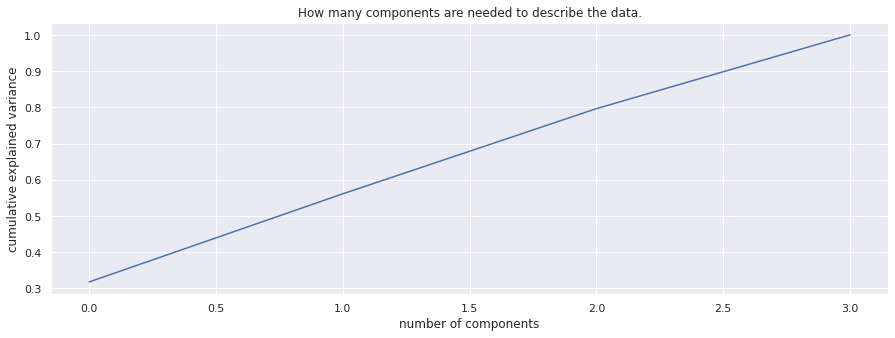

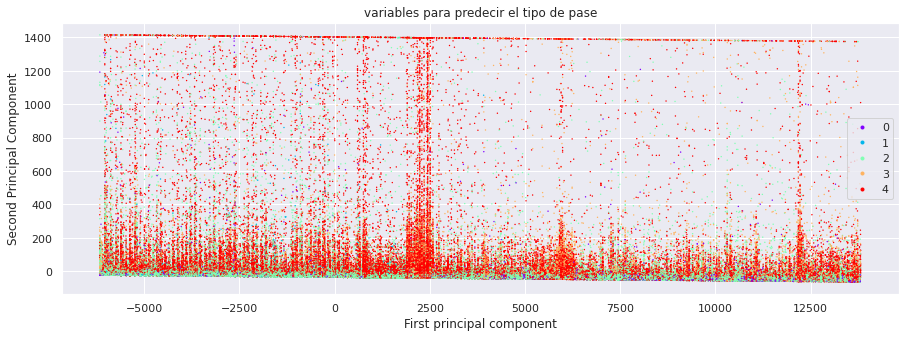

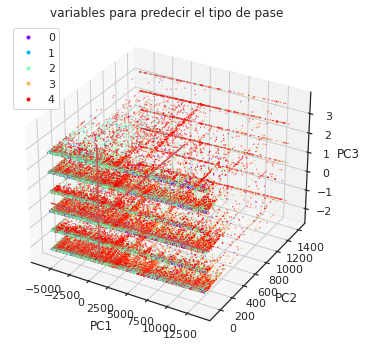

In [33]:
pca_object = pca(df_model, titulo="variables para predecir el tipo de pase", label_y='passholder_type')
pca_object.pca_2D(); pca_object.pca_3D()

In [34]:
X = df_model.iloc[:,:-1]
y = df_model.iloc[:,-1]


In [35]:
from libraries import *

In [36]:
# best_params = RKFold(X,y)

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,stratify=y, shuffle=True)
grid, df_grid, grid_report= Gridsearchcv(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END clf__selected_model=('gb', {'learning_rate': 0.1, 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 0.8}); F1: (train=0.725, test=0.696) acc: (train=0.725, test=0.696) pr: (train=0.725, test=0.696) rc: (train=0.725, test=0.696) total time= 8.9min
[CV 3/3] END clf__selected_model=('gb', {'learning_rate': 0.1, 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 0.8}); F1: (train=0.726, test=0.694) acc: (train=0.726, test=0.694) pr: (train=0.726, test=0.694) rc: (train=0.726, test=0.694) total time= 8.9min
[CV 1/3] END clf__selected_model=('gb', {'learning_rate': 0.1, 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 0.8}); F1: (train=0.725, test=0.695) acc: (train=0.725, test=0.695) pr: (train=0.725, test=0.695) rc: (train=0.725, test=0.695) total time= 9.0min
Best-Fit Parameters From Training Data:
 {'clf__selected_model': ('gb', {'learning_rate':

In [39]:
model = GradientBoostingClassifier()()

params = [{
    "learning_rate": [0.1],
    "max_depth":[8,9,10],
    "max_features":["sqrt"],
    "subsample":[0.8],
    "n_estimators":[100],}]

clf = GridSearchCV(model, params, cv = 3, scoring='accuracy')

clf.fit(X_train, y_train)

TypeError: 'GradientBoostingClassifier' object is not callable